=== Tabla resumida ===


,PR_AUC,F1,notes
model,,,
lightgbm_baseline,0.126196,0.189745,LightGBM baseline
xgboost_grid,0.120312,0.247788,"XGBoost (grid_search, umbral óptimo)"
rf_optimized,0.105600,0.205900,RandomForest (optimizado)


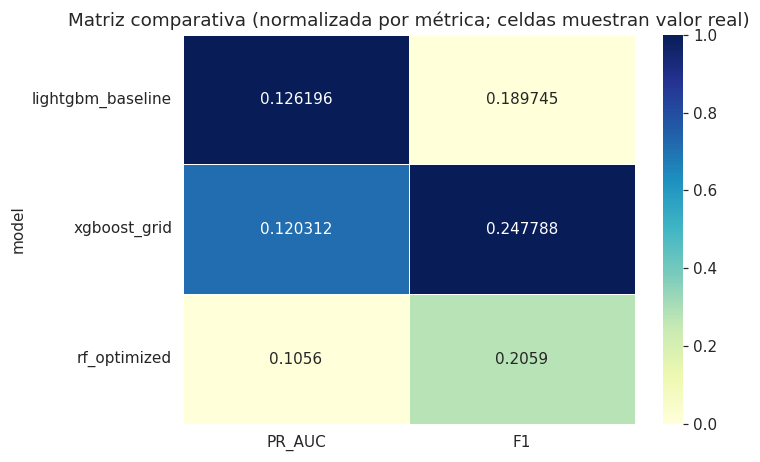

/tmp/ipykernel_646947/2477243999.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=metric, y="model", data=plot_df.sort_values(metric, ascending=False), palette=pal_list)


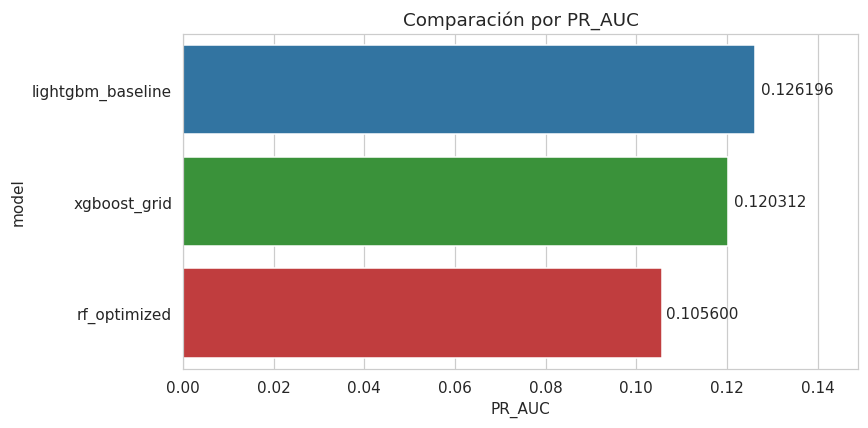

/tmp/ipykernel_646947/2477243999.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=metric, y="model", data=plot_df.sort_values(metric, ascending=False), palette=pal_list)


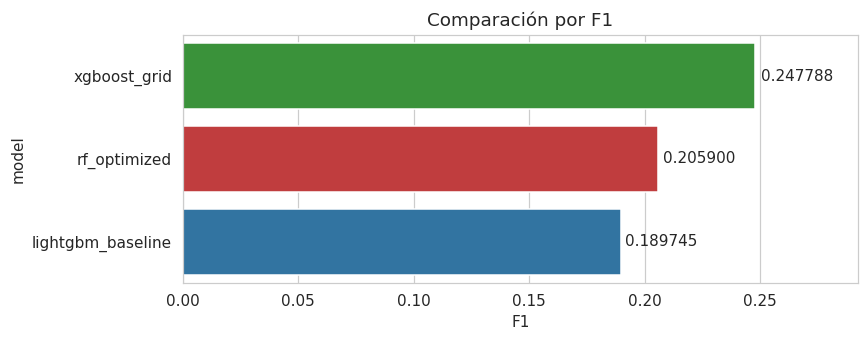

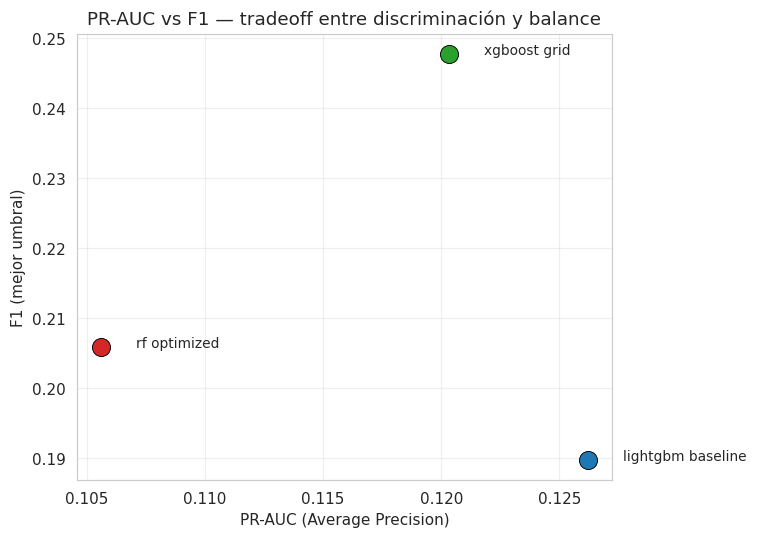

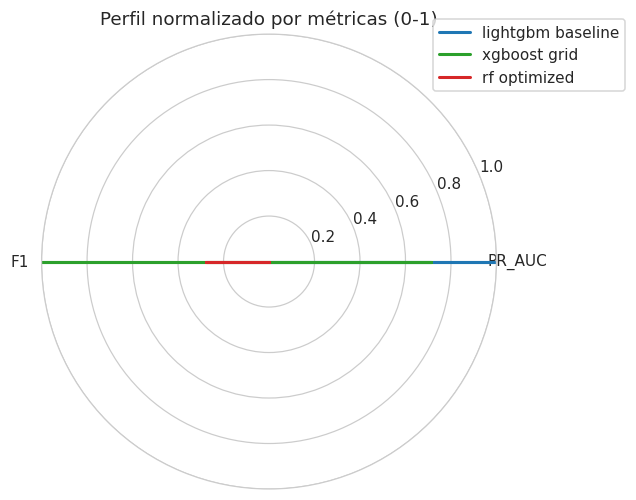

In [11]:
# Celda unica: visualizaciones comparativas (PR-AUC / F1) con colores consistentes por modelo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams["figure.dpi"] = 110

# --- 1) Datos ---
rows = [
    {"model":"lightgbm_baseline", "PR_AUC": 0.126196, "F1": 0.189745, "notes":"LightGBM baseline"},
    {"model":"xgboost_grid",       "PR_AUC": 0.120312, "F1": 0.247788, "notes":"XGBoost (grid_search, umbral óptimo)"},
    {"model":"rf_optimized",       "PR_AUC": 0.105600, "F1": 0.205900, "notes":"RandomForest (optimizado)"}
]
df = pd.DataFrame(rows).set_index("model")

# --- Color map consistente: ajusta hex si prefieres otros tonos ---
color_map = {
    "lightgbm_baseline": "#1f77b4",  # azul
    "xgboost_grid":       "#2ca02c",  # verde
    "rf_optimized":       "#d62728"   # rojo
}
# fallback color
default_color = "#7f7f7f"

# --- 2) Tabla resumen (ordenada por PR_AUC) ---
df_sorted = df.sort_values("PR_AUC", ascending=False)
print("=== Tabla resumida ===")
display(df_sorted.style.format({"PR_AUC":"{:.6f}","F1":"{:.6f}"}))

# --- 3) Heatmap normalizado por columna (min-max) ---
metrics = ["PR_AUC","F1"]
hm = df_sorted[metrics].copy()
# Normalizar 0-1 por columna para color; evitar división por cero
denom = (hm.max() - hm.min()).replace(0, 1)
hm_norm = (hm - hm.min()) / denom
hm_norm = hm_norm.fillna(0)

plt.figure(figsize=(7, 0.9 * len(hm_norm) + 1.6))
sns.heatmap(hm_norm, annot=hm.round(6), fmt="", cmap="YlGnBu", cbar=True, linewidths=0.6)
plt.title("Matriz comparativa (normalizada por métrica; celdas muestran valor real)")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# --- 4) Barras: PR_AUC y F1 (por separado) con colores consistentes ---
for metric, height in [("PR_AUC", 4.0), ("F1", 3.2)]:
    plt.figure(figsize=(8, height))
    plot_df = df_sorted[[metric]].reset_index()
    # construir palette ordenada que seaborn acepta: lista de colores en el orden de plot_df['model']
    pal_list = [color_map.get(m, default_color) for m in plot_df.sort_values(metric, ascending=False)['model'].values]
    ax = sns.barplot(x=metric, y="model", data=plot_df.sort_values(metric, ascending=False), palette=pal_list)
    plt.title(f"Comparación por {metric}")
    # Anotar valores al final de cada barra
    sorted_vals = plot_df.sort_values(metric, ascending=False)[metric].values
    for i, val in enumerate(sorted_vals):
        ax.text(val + max(1e-6, val*0.01), i, f"{val:.6f}", va="center")
    plt.xlim(0, plot_df[metric].max() * 1.18)
    plt.tight_layout()
    plt.show()

# --- 5) Scatter PR_AUC vs F1 (muestra tradeoff) con colores consistentes ---
plt.figure(figsize=(7,5))
x = df_sorted["PR_AUC"].values
y = df_sorted["F1"].values
models = df_sorted.index.tolist()
for i, m in enumerate(models):
    c = color_map.get(m, default_color)
    plt.scatter(x[i], y[i], s=140, color=c, edgecolor='k', linewidth=0.6)
    plt.text(x[i] + 0.0015, y[i], m.replace("_"," "), fontsize=9)
plt.xlabel("PR-AUC (Average Precision)")
plt.ylabel("F1 (mejor umbral)")
plt.title("PR-AUC vs F1 — tradeoff entre discriminación y balance")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# --- 6) Radar (spider) normalizado: usar mismos colores ---
vals = hm_norm.values
labels = metrics
N = len(labels)
angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist()
angles += angles[:1]  # cerrar
plt.figure(figsize=(6,6))
ax = plt.subplot(111, polar=True)
for i, model in enumerate(hm_norm.index):
    data = hm_norm.loc[model].values.tolist()
    data += data[:1]
    c = color_map.get(model, default_color)
    ax.plot(angles, data, label=model.replace("_"," "), color=c, linewidth=2)
    ax.fill(angles, data, alpha=0.15, color=c)
ax.set_thetagrids(np.degrees(angles[:-1]), labels)
ax.set_ylim(0,1)
ax.set_title("Perfil normalizado por métricas (0-1)")
ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.05))
plt.tight_layout()
plt.show()
